In [1]:
import numpy
import matplotlib.patches as patches
from matplotlib import colors
import mitsuba as mi
mi.set_variant("cuda_ad_rgb")
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
import matplotlib.patches as patches
from PDE2D import PATH

In [2]:

radius = 0.14
box_length = 2.1 * radius
box_center = [0,0]
bbox_sdf = [[box_center[0] - box_length/2, box_center[1] - box_length/2],
        [box_center[0] + box_length/2, box_center[1] + box_length/2]]

bbox = [[box_center[0] -  box_length/2, box_center[1] - box_length/2],
        [box_center[0] +  box_length/2, box_center[1] +  box_length/2]]

resolution = [1024, 1024]
upsample = 1


In [3]:
radius = 0.3
origin = mi.Point2f(0.2, 0.1)
low_distance = 0.01
high_distance = 0.05
circle = CircleShape(origin = origin, radius = radius)


In [4]:
out_boundary = CircleWithElectrodes(radius = 1, injection_confs = [[0,10], [1,2]], is_delta = True)
shape = BoundaryWithDirichlets(out_boundary, [circle], dirichlet_values = [[0]])
data_holder = DataHolder(shape)
wos = WostConstant(input=data_holder)

In [5]:
res = 256
spp = 2 ** 23
close_points, _, dir_low  = circle.create_boundary_points(low_distance, res = res, spp = spp)
far_points, _, dir_high  = circle.create_boundary_points(high_distance, res = res, spp = spp)

In [6]:
close_results = []
far_results = []
for i in range(32):
    wos.change_seed(i)
    L_low, _ = wos.solve(close_points, derivative_dir= dir_low)
    L_high, _ = wos.solve(far_points, derivative_dir= dir_low)
    close_result = create_circle_from_result(L_low, res)
    far_result = create_circle_from_result(L_high, res)
    close_results.append(close_result)
    far_results.append(far_result)
    print(i)

close_result = np.mean(np.array(close_results), axis = 0)
far_result_ = np.mean(np.array(far_results), axis = 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


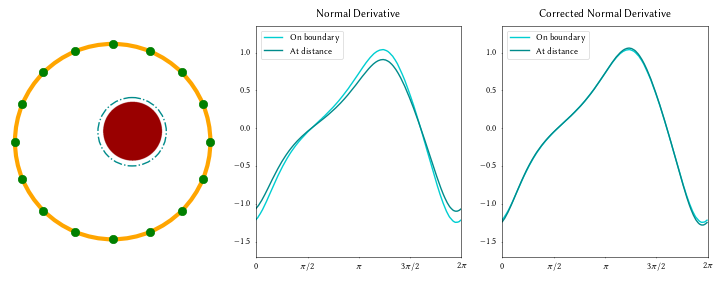

In [7]:
lw = 1
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (9,3))
image = wos.input.shape.sketch_image(ax1, bbox, resolution)
image[(image[:,:,0] < 0.01) & (image[:,:,1] < 0.01)] = 1

ax1.imshow(image)
ind = np.arange(res)/res * 2 * np.pi

correct_result = (radius + low_distance) / radius * close_result[0].squeeze()
far_result = far_result_[0].squeeze()
far_correct_result = (radius + high_distance) / radius * far_result

#min_val = min(min(np.min(correct_result), np.min(far_result)), np.min(far_correct_result))
#max_val = max(max(np.max(correct_result), np.max(far_result)), np.max(far_correct_result))

range = [-1.7, 1.35]

ax2.plot(ind, correct_result, label = "On boundary", linewidth = lw, color = "darkturquoise")
ax2.plot(ind, far_result, label =  "At distance", linewidth = lw, color = "darkcyan")

ax3.plot(ind, correct_result, label=  "On boundary", linewidth = lw, color = "darkturquoise")
ax3.plot(ind,  far_correct_result, label =  "At distance", linewidth = lw, color = "darkcyan")

ax2.set_xticks([0, np.pi/2, np.pi, 3 * np.pi / 2, 2* np.pi-0.01])
ax2.set_xticklabels(["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
ax3.set_xticks([0, np.pi/2, np.pi, 3 * np.pi / 2, 2* np.pi-0.01])
ax3.set_xticklabels(["0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
ax2.set_xlim([0,2*np.pi-0.01])
ax3.set_xlim([0,2*np.pi-0.01])

ax2.legend()
ax3.legend()

rplot,_,_ = dist2sketch(radius + high_distance, bbox, resolution)
o = point2sketch(origin, bbox, resolution).numpy()
sphere = patches.Ellipse([o[0] - 0.5, o[1]-0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "darkcyan", label = "Sim Points", ls="-.", linewidth = lw)
ax1.add_patch(sphere)

ax2.set_ylim(range)
ax3.set_ylim(range)
ax2.set_title("Normal Derivative")
ax3.set_title("Corrected Normal Derivative")
plt.savefig(os.path.join(PATH, "figures", "png", "dist", f"dist{high_distance}.png"), bbox_inches='tight', pad_inches=0.04, dpi=750)